# Chess Challenge

Welcome to the chess challenge of the MQST Qiskit Fall Fest!

The queens puzzle is the problem of placing the maximum number of chess queens on an $N \times N$ chessboard such that no two queens threaten each other. It is often used as an example in various computational techniques. This problem does not have a unique solution, and the complexity of finding one increases exponentially with the size of $N$.

#### First install the necessary packages:

In [ ]:
# Uncomment to install the necessary packages

'''
%pip install --upgrade pip
%pip install numpy==2.3.4
%pip install scipy==1.16.2
%pip install matplotlib==3.10.7
%pip install jupyter
%pip install qiskit[visualization]==2.2
# # For Local Linux or Mac, you can use the following command:
# # %pip install 'qiskit[visualization]'
%pip install qiskit_algorithms==0.4.0
%pip install qiskit_aer==0.17.2
%pip install qiskit_ibm_runtime==0.41.1
%pip install qiskit_ibm_transpiler==0.14.3
'''

In [22]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_aer import AerSimulator
from math import pi
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Map piece names to unicode symbols
piece_unicode = {
    'queen': '♛',
    'rook': '♜',
    'bishop': '♝',
    'horse':'♞'
}

def plot_checkerboard(matrix, piece_type='queen'):
    """
    Plots a checkerboard with a single type of piece.
    
    Parameters:
        matrix (ndarray): n x n array of 0s and 1s
        piece_type (str): 'queen', 'rook', or 'bishop'
    """
    n = matrix.shape[0]
    
    # Checkerboard colors
    board_colors = np.zeros((n, n, 3))
    for i in range(n):
        for j in range(n):
            board_colors[i, j] = [1, 1, 1] if (i + j) % 2 == 0 else [0.8, 0.8, 0.8]

    fig, ax = plt.subplots(figsize=(n, n))
    ax.imshow(board_colors, extent=[0, n, 0, n])

    # Plot pieces
    symbol = piece_unicode.get(piece_type, '♛')
    for i in range(n):
        for j in range(n):
            if matrix[i, j] == 1:
                ax.text(j + 0.5, n - i - 0.5, symbol,
                        fontsize=30, ha='center', va='center', color='red')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect('equal')
    plt.show()


# 1- Starting from the basics: before queens there were rooks

To start slowly, we will solve the problem for rooks, for which is much easier to find a solution but has the disadvantage that there are many more solutions. What is the max number of rooks that can fit in a 4x4 chess board? And on a 5x5?

## The first task is to create a classical function that by brute force gives the solutions for the rooks puzzle for NxN chess board.

> Tip: Represent the chess board by an NxN array filled with 0 for the empty squares and by 1 for the squares in which a rook is placed. This representation will also help you during great part of this challenge

In [8]:
def classical_rooks(N):
    """Returns the solutions of the rooks puzzle for NxN chess board.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        solutions (np.ndarray): The solutions of the rooks puzzle.
    """
    # Your code here

    solutions = []
    board = np.zeros((N, N), dtype=int) #board template
    cols_used = set() #empty set to store multiple variables

    #funcion recursiva
    
    def repesca(row):
        if row == N:
            # If it iterated for all rows, found a valid configuration
            #solution=[0,0,0]
            #for i in range(N):
                #solution[i]=np.nonzero(board.copy()[i])[0][0]+1
                
            #solutions.append(solution)
            solutions.append(board.copy()) #store a copy of board

        for col in range(N):
            if col not in cols_used:
                board[row, col] = 1 #mete una rook en la cell [row,col]
                cols_used.add(col) #guarda la columna usada

                repesca(row + 1) # estudia la siguiente fila una vez añadida la rook

                # backtrack: deshace el resultado para estudiar que pasa si pones la rook en la siguiente col ( recursividad )
                board[row, col] = 0
                cols_used.remove(col)
    
    repesca(0)
    return np.array(solutions)

#classical_rooks(3)

Computing the available solutions by brute force is expensive and untractable when dealing with bigger boards, so we will take advantaje of the hybrid algorithm QAOA to solve this problem in a different way, phrasing the problem as a physics optimization problem, namely finding the state with lowest energy for a given hamiltonian.

The general form of a optimization problem can be written on the form of a hamiltonian:

$$H_C = \sum_{i,j} Q_{ij} X_i X_j + \sum_i b_i X_i$$

where $X_i$ are classical variables can be 1 or 0 and the coefficients $b_i$ and $Q_{ij}$ are problem dependent.

To find a solution using qubits, first we need to map the qubits form a quantum circuit to represent our problem. For that, one suggestion is to use the following mapping:
- Each qubit will represent one square of the chess board, so it will be identified by row and column indices.
- If there is a piece on that square, the spin will be on state $|1>$, and if it is empty the state will be $|0>$

<p style="text-align: center"><img src="https://i.imgur.com/ojkY5to.jpeg"></p>


> Example 3x3 board:
- q0 in state 0 -> 0,0
- q1 in state 0 -> 0,1
- q2 in state 0 -> 0,2
- q3 in state 0 -> 1,0
- q4 in state 0 -> 1,1
- q5 in state 1 -> 1,2
- q6 in state 0 -> 2,0
- q7 in state 0 -> 2,1
- q8 in state 0 -> 2,2

This is just a suitable mapping but it is not unique. There are many more mappings that can be used for this problem, so if you have any other please explain it and use it!!!

For the previous mapping we need $N^2$ qubits to find a solution for a NxN chess board, so a way to improve this mapping could be to reduce the number of qubits needed to map the problem. A new mapping will also change some of the following instructions... be carefull with that!!

To adapt the expression to our problem, we will change the single index $i$ of the classical variables to the actual chess board indices, where latin letters will be rows and greek indices will be columns. Therefore, the classical hamiltonian for our mapping is of the form:

$$H_C = \sum_{k,\alpha ,l,\beta} Q_{k \alpha,l \beta} X_{k\alpha}X_{l\beta} + \sum_{k\alpha} b_{k\alpha} X_{k\alpha}$$

Moreover, we need to define a specific hamiltonian whose groundstate is a solution of the rooks puzzle. For that, we will need two terms:
- One term that lowers the energy with the number of rooks ($|1>$ states)
> Tip: this is a one-body term
- One term that increases the energy if one rook threatens other. This penalization should be bigger than the energy gained by adding one other rook
> Tip: this is a two body interaction term

 Define the weigths $b_{k\alpha}$ and $Q_{k\alpha, l\beta}$ such that the previous cost function has as ground state the solution of the rook's puzzle. Make the cost of threatening 1.5 times the benefit of adding one extra rook (one extra $X$ with 1 value)

> Tip: Adding one more rook DECREASES energy, therefore $b<0$, and having threatened rooks should INCREASE it, therefore $Q>0$. Use $b=-1$ and $Q=1.5$ for those cases where the value is non-zero.

> Tip2: The rooks in chess only move vertical and horizontal, so the only relevant $Q$ coefficients are those for which $k=l$ or $\alpha=\beta$.

In [ ]:
def classical_hamiltonian_rook_onebody_coeff(N: int) -> np.ndarray:

    # b_{kα} = b_k = -1  → adding a rook anywhere has cost of -1

    b_k = -1.0
    b_tensor = np.zeros((N, N, N, N))

    for i in range(N):
        for j in range(N):
            b_tensor[i][j][i][j]=b_k

    return b_tensor


print(classical_hamiltonian_rook_onebody_coeff(3))

In [ ]:

def classical_hamiltonian_rooks_twobody_coeff(N: int) -> np.ndarray:

    '''
    #Returns the NxNxNxN tensor Q_{kα, lβ} of pairwise interaction weights for the classical rooks problem.
    # Q[k, α, l, β] = 1.5 if squares (k, α) and (l, β) are in the same row or column, and 0 otherwise.

    Q_k = 1.5
    Q_tensor = np.zeros((N, N, N, N))

    for k in range(N):         # row index of first rook
        for alpha in range(N): # col index of first rook
            for l in range(N): # row index of second rook
                for beta in range(N): # col index of second rook
                    if (k == l and alpha == beta):
                        continue  # same square → no self-interaction
                    # If same row or same column
                    if k == l or alpha == beta:
                        Q_tensor[k, alpha, l, beta] = Q_k

    '''

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]

    conflict = ((rows == rows2) | (cols == cols2)) & ~((rows == rows2) & (cols == cols2))
    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k

    print(Q_tensor)

    return Q_tensor

#Repetir poniendo una mascara?

H_Q=classical_hamiltonian_rooks_twobody_coeff(3)

In [ ]:
def classical_hamiltonian_rooks(N: int, X_string: np.ndarray) -> float:

    H_b= classical_hamiltonian_rook_onebody_coeff(N)
    H_Q=classical_hamiltonian_rooks_twobody_coeff(N)

    H = H_b + H_Q

    # First, reshape x to (N,N,1,1) and (1,1,N,N)
    x1 = X_string[:,:,None,None]
    x2 = X_string[None,None,:,:]

    # Elementwise multiply and sum
    energy = np.sum(H * x1 * x2)

    return energy

state=np.array([[1,1,0],[0,0,0],[0,0,0]])
classical_hamiltonian_rooks(3,state)

As our system is a quantum system where the hamiltonian is an operator, whe should write it in terms of known operators. For that, we will do the change of variable
$$X_{k\alpha} = \frac{1-\hat\sigma^z_{k\alpha}}{2}$$
where $\hat \sigma^z_{k\alpha}$ is the Pauli Z operator acting on the qubit that represents the square of row $k$ and column $\alpha$. Introducing this change of variable on the previous function, you will obtain a quantum operator of the same form with an extra constant term that can be neglected because it only changes the origin of the energy.

> Hint: For this step you might need some pen and paper calculations to find the transformation!

## Write the new hamiltonian and create the associated functions to find the new coefficients

__Write here your hamiltonian__

In [162]:
def quantum_hamiltonian_onebody(N):
    """Returns the NxN matrix of b_{k \alpha} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        b_vector (np.array): The NxN matrix of b_{k \alpha} weigths.
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
    """
    # Your code here

    # Parámetros del término clásico
    b_k = -1.0
    factor = 0.5 * b_k 

    n_qubits = N * N

    # Lista de labels strings de matrices pauli
    labels = []
    coeffs = [] # 

    for i in range(N):
        for j in range(N):
            q = i * N + j
            label = ['I'] * n_qubits 
            label[n_qubits - 1 - q] = 'Z'  #El Qubit 0 es último carácter del string por convención Qiskit
            labels.append(''.join(label))
            coeffs.append(factor)

    # Crear el operador cuántico
    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))

    return H

def quantum_hamiltonian_rook_twobody(N, Q_k=1.5):
    """
    Two-body Hamiltonian for rooks conflicts (rows and columns).
    Using n_i n_j = (I - Z_i)/2 * (I - Z_j)/2
    """
    n_qubits = N * N
    labels = []
    coeffs = []

    # Create conflict tensor: 1 if two positions share row or column (excluding same square)
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if k == l and alpha == beta:
                        continue  # same square
                    if k == l or alpha == beta:  # same row or column
                        q1 = k * N + alpha
                        q2 = l * N + beta
                        # Expand (I - Z_i)/2 * (I - Z_j)/2 = 0.25*I - 0.25*Z_i - 0.25*Z_j + 0.25*Z_i Z_j
                        
                        # 0.25 * I
                        label_I = 'I' * n_qubits
                        labels.append(label_I)
                        coeffs.append(0.25 * Q_k)

                        # -0.25 * Z_i
                        label_Zi = ['I'] * n_qubits
                        label_Zi[n_qubits - 1 - q1] = 'Z'
                        labels.append(''.join(label_Zi))
                        coeffs.append(-0.25 * Q_k)

                        # -0.25 * Z_j
                        label_Zj = ['I'] * n_qubits
                        label_Zj[n_qubits - 1 - q2] = 'Z'
                        labels.append(''.join(label_Zj))
                        coeffs.append(-0.25 * Q_k)

                        # +0.25 * Z_i Z_j
                        label_ZiZj = ['I'] * n_qubits
                        label_ZiZj[n_qubits - 1 - q1] = 'Z'
                        label_ZiZj[n_qubits - 1 - q2] = 'Z'
                        labels.append(''.join(label_ZiZj))
                        coeffs.append(0.25 * Q_k)

    print(coeffs)
    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    return H


In [163]:
def quantum_hamiltonian_rooks_twobody_opt(N,Q_k=1.5):
    """Returns the NxNxNxN array of Q_{k \alpha, l \beta} weigths.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        Q_matrix (np.array): The NxNxNxN array of Q_{k \alpha, l \beta} weigths.
    """
    # Your code here
    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]
    
    conflict = ((rows == rows2) | (cols == cols2)) & ~((rows == rows2) & (cols == cols2))
    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k
    
    #print(Q_tensor)

    # Loop over pairs of squares to create ZZ terms
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if k == l and alpha == beta:
                        continue
                    J = 0.25 * Q_tensor[k, alpha, l, beta]
                    if J == 0:
                        continue
                    q1 = k * N + alpha
                    q2 = l * N + beta
                    label = ['I'] * n_qubits
                    label[n_qubits - 1 - q1] = 'Z'
                    label[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label))
                    coeffs.append(J)

    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    return H

Now, we are able construct the hamiltonian for our problem, using the previous coefficients to create a quantum operator.

## Write a function that creates the hamiltonian of the rooks puzzle as a SparsePauliOp
> Tip: Use the previous functions to obtain the coefficients of the hamiltonian

In [164]:
def cost_hamiltonian_rooks(N):
    """Returns the hamiltonian of the rooks puzzle as a SparsePauliOp.

    Args:
        N (int): The dimension of the chess board.

    Returns:
        hamiltonian (SparsePauliOp): The hamiltonian of the rooks puzzle.
    """
    # Your code here
    
    # One-body Hamiltonian
    H_one = quantum_hamiltonian_onebody(N)
    
    # Two-body Hamiltonian
    H_two = quantum_hamiltonian_rooks_twobody_opt(N)
    
    # Sum the Hamiltonians
    hamiltonian = H_one + H_two

    return hamiltonian

# 1.1 Finding solutions for the rook puzzle

Now that we have constructed the hamiltonian that encodes the solution of the problem, we just need to find the groundstate of it.
For that we will use the QAOA algorithm, where the circuit is optimized to find a groundstate of the cost function.

In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal parameters.
Check [QAOAAnsatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz), and using scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function run the QAOA algorithm to find the solution of the rooks puzzle, using only two layers.

> Note: There is an [example at IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) but it contains the way to run the algorithm on real hardware which up to now it is not the goal. **Check it to get inspiration but run this optimization locally using AerSimulator** or any other simulated backend.

> Note 2: The solution might not be unique


In [165]:
def cost_function_rooks_estimator(cost_hamiltonian: SparsePauliOp, qc: QuantumCircuit) -> float:
    # Get final statevector
    state = Statevector.from_instruction(qc)
    
    # Compute expectation value of the cost Hamiltonian
    energy = state.expectation_value(cost_hamiltonian)
    
    return np.real(energy)

In [192]:

def QAOA(N, cost_hamiltonian, label = "Rooks", p=2):
    n_qubits = N * N
    simulator = AerSimulator()
    energy_progress = []

    def qaoa_circuit(params):
        gamma = params[:p]
        beta = params[p:]
        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))  # initial superposition

        for layer in range(p):
            # Cost unitary
            for label, coeff in zip(cost_hamiltonian.paulis.to_labels(), cost_hamiltonian.coeffs):
                coeff_real = np.real(coeff)  # <-- ensure it's real
                qubits = [i for i, c in enumerate(label[::-1]) if c == 'Z']
                if len(qubits) == 1:
                    qc.rz(2 * coeff_real * gamma[layer], qubits[0])
                elif len(qubits) == 2:
                    qc.cx(qubits[0], qubits[1])
                    qc.rz(2 * coeff_real * gamma[layer], qubits[1])
                    qc.cx(qubits[0], qubits[1])
            # Mixer
            for q in range(n_qubits):
                qc.rx(2 * beta[layer], q)
        return qc

    def objective(params):
        qc = qaoa_circuit(params)
        energy = cost_function_rooks_estimator(cost_hamiltonian, qc)
        energy_progress.append(energy)
        return energy

    # Initial random parameters
    x0 = np.random.rand(2 * p) * np.pi
    
    #result = minimize(objective, x0)
    
    #Good
    result = minimize(objective, x0, method='COBYLA')
    
    #Better
    #result = minimize(objective, x0, method='Nelder-Mead', options={'maxiter':10000, 'xatol':1e-6, 'fatol':1e-6})

    optimal_params = result.x
    min_energy = result.fun
    
    qc_opt = qaoa_circuit(optimal_params)
    
    # Plot energy at each optimization step
    plt.figure(figsize=(8, 5))
    plt.plot(energy_progress, marker='o')
    plt.xlabel("Function Evaluation")
    plt.ylabel("Energy")
    plt.title(f"QAOA Energy Progress for {N}x{N} {label}")
    plt.grid(True)
    plt.show()

    return optimal_params, min_energy, qc_opt

In [ ]:
def QAOA(N, cost_hamiltonian, label = "Rooks", p=2):
    n_qubits = N * N
    simulator = AerSimulator()
    energy_progress = []

    def qaoa_circuit(params):
        gamma = params[:p]
        beta = params[p:]
        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))  # initial superposition

        for layer in range(p):
            # Cost unitary
            for label, coeff in zip(cost_hamiltonian.paulis.to_labels(), cost_hamiltonian.coeffs):
                coeff_real = np.real(coeff)  # <-- ensure it's real
                qubits = [i for i, c in enumerate(label[::-1]) if c == 'Z']
                if len(qubits) == 1:
                    qc.rz(2 * coeff_real * gamma[layer], qubits[0])
                elif len(qubits) == 2:
                    qc.cx(qubits[0], qubits[1])
                    qc.rz(2 * coeff_real * gamma[layer], qubits[1])
                    qc.cx(qubits[0], qubits[1])
            # Mixer
            for q in range(n_qubits):
                qc.rx(2 * beta[layer], q)
        return qc

    def objective(params):
        qc = qaoa_circuit(params)
        energy = cost_function_rooks_estimator(cost_hamiltonian, qc)
        energy_progress.append(energy)
        return energy

    # Initial random parameters
    x0 = np.random.rand(2 * p) * np.pi
    result = minimize(objective, x0, method='COBYLA')
    
    optimal_params = result.x
    min_energy = result.fun
    
    qc_opt = qaoa_circuit(optimal_params)

    return optimal_params, min_energy, qc_opt

In [227]:
def QAOA_Qk(N, cost_hamiltonian, p=2, label='Queens', maxiter=50):
    # Write here a function that using the cost_function_rooks_estimator optimizes the QAOA parameters to
    # find the solution of the rooks puzzle ()

    n_qubits = N * N
    energy_progress = []

    # Precompute Hamiltonian matrix once
    H_matrix = cost_hamiltonian.to_matrix()

    # Build QAOA ansatz (this is already a QuantumCircuit)
    qaoa_ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p, mixer_operator=None)
    num_params = len(qaoa_ansatz.parameters)

    def objective(params):
        # Assign parameters directly to the ansatz
        bound_qc = qaoa_ansatz.assign_parameters(params)
        sv = Statevector.from_instruction(bound_qc)
        energy = np.real(sv.expectation_value(H_matrix))
        energy_progress.append(energy)
        return energy

    # Random initial parameters
    x0 = np.random.uniform(0, np.pi, num_params)

    # Use COBYLA for faster convergence
    result = minimize(objective, x0, method="COBYLA", options={'maxiter': maxiter, 'tol': 1e-3})
    optimal_params = result.x
    min_energy = result.fun

    # Build optimal circuit and compute final probabilities
    qc_opt = qaoa_ansatz.assign_parameters(optimal_params)
    sv_opt = Statevector.from_instruction(qc_opt)
    probs = sv_opt.probabilities_dict()

    # Plot energy progress
    plt.figure(figsize=(8,5))
    plt.plot(energy_progress, marker='o')
    plt.xlabel("Function Evaluation")
    plt.ylabel("Energy")
    plt.title(f"QAOA Energy Progress for {N}x{N} {label} (p={p})")
    plt.grid(True)
    plt.show()

    return optimal_params, min_energy, qc_opt

## Run the QAOA algorithm for 3x3 and 4x4 boards and discuss the solutions obtained.
## Compare the solutions with the ones obtained by brute force.

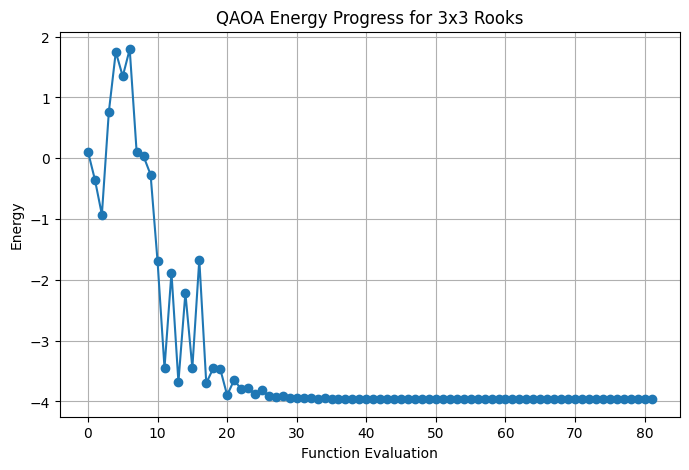

Optimal parameters: [0.78849665 3.7261469  1.65188385 1.95593206]
Minimum energy found: -3.964038246241201


In [166]:
def rooks_problem_run(N):

    # Build cost Hamiltonian
    Cost_H = cost_hamiltonian_rooks(N)
    
    # Run QAOA
    optimal_params, min_energy, qc_opt = QAOA(N, Cost_H, p=2)

    print("Optimal parameters:", optimal_params)
    print("Minimum energy found:", min_energy)
    
    # Compute final state
    state = Statevector.from_instruction(qc_opt)

    # Get probabilities of each computational basis state (dict keeps insertion order in Python 3.7+)
    probs = state.probabilities_dict()

    # Keep original order
    states = list(probs.keys())
    probs_list = list(probs.values())

    # Find the most probable (minimum energy) states
    max_prob = max(probs_list)
    min_energy_states = [bitstring for bitstring, prob in probs.items() if np.isclose(prob, max_prob)]

    # Save everything you’ll need later
    results = {
        "N": N,
        "optimal_params": optimal_params,
        "min_energy": min_energy,
        "states": states,
        "probs_list": probs_list,
        "min_energy_states": min_energy_states,
        "probs": probs,
    }

    return results

# Run for a 3x3 board and store results
results_rook_3 = rooks_problem_run(3)


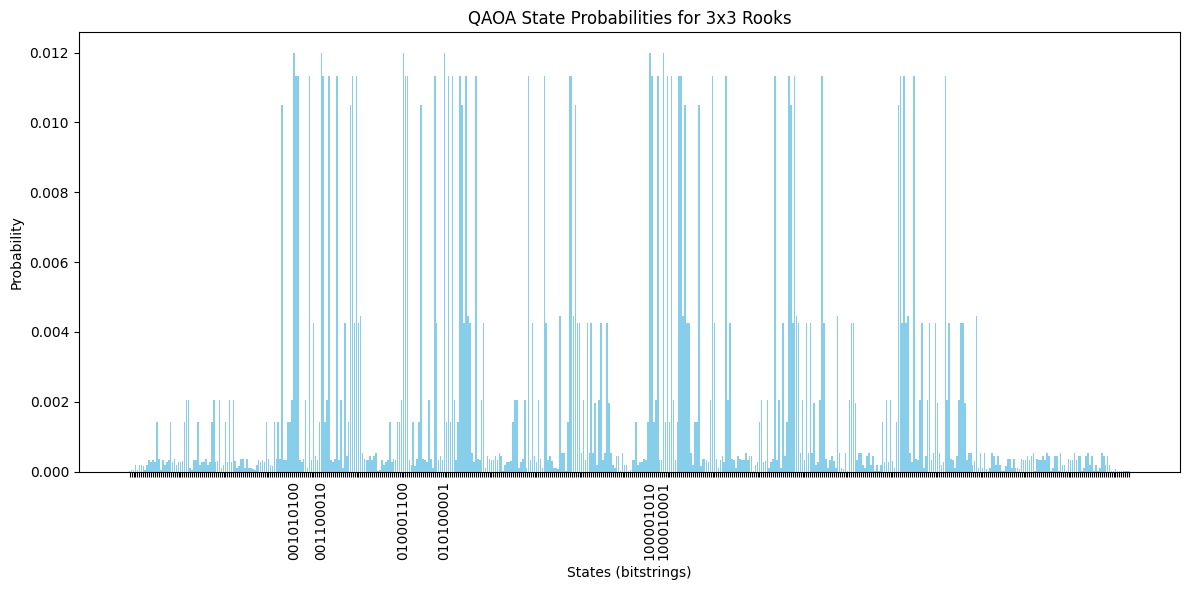

Most probable (minimum energy) states:
['001010100', '001100010', '010001100', '010100001', '100001010', '100010001']
Solution 1:


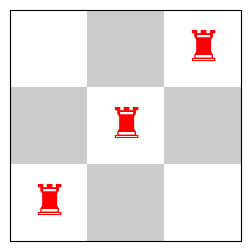


Solution 2:


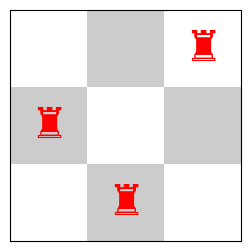


Solution 3:


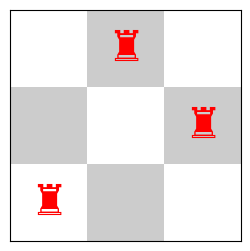


Solution 4:


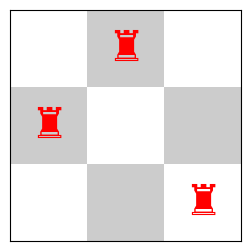


Solution 5:


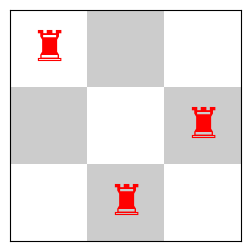


Solution 6:


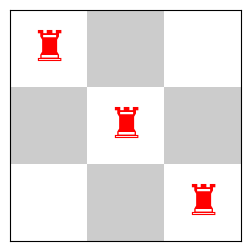

In [167]:
# Extract results
N = results_rook_3["N"]
states = results_rook_3["states"]
probs_list = results_rook_3["probs_list"]
min_energy_states = results_rook_3["min_energy_states"]

# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]

# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Rooks")
plt.tight_layout()
plt.show()

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='rook')
    print()

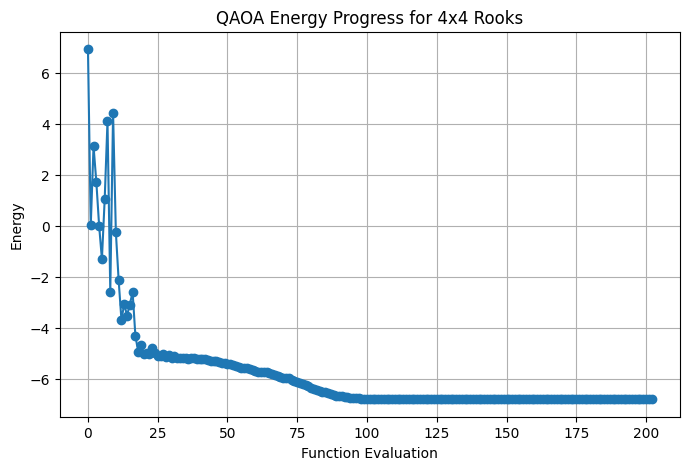

Optimal parameters: [ 4.02121175 -0.26274852  2.90913334  1.31438252]
Minimum energy found: -6.809101323150352


In [168]:
results_rook_4 = rooks_problem_run(4)


Most probable (minimum energy) states:
['0001001001001000', '0001001010000100', '0001010000101000', '0001010010000010', '0001100000100100', '0001100001000010', '0010000101001000', '0010000110000100', '0010010000011000', '0010010010000001', '0010100000010100', '0010100001000001', '0100000100101000', '0100000110000010', '0100001000011000', '0100001010000001', '0100100000010010', '0100100000100001', '1000000100100100', '1000000101000010', '1000001000010100', '1000001001000001', '1000010000010010', '1000010000100001']
Solution 1:


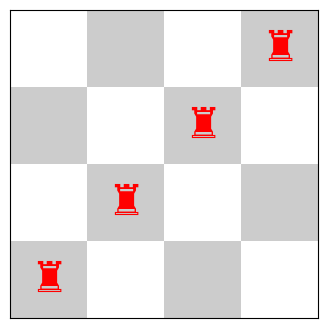


Solution 2:


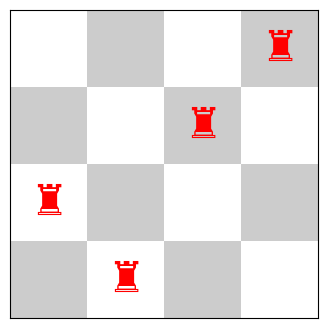


Solution 3:


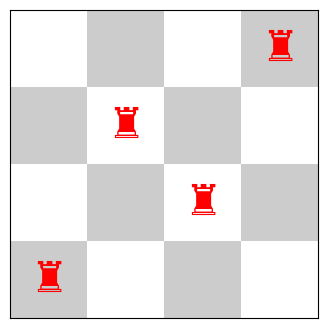


Solution 4:


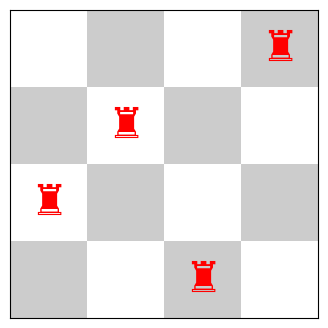


Solution 5:


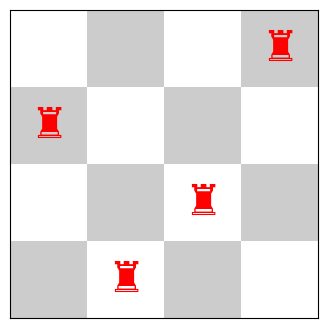


Solution 6:


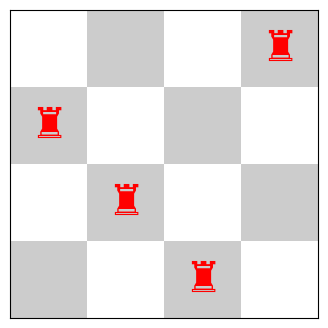


Solution 7:


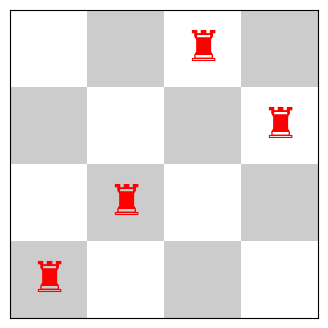


Solution 8:


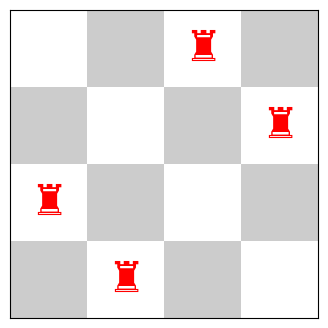


Solution 9:


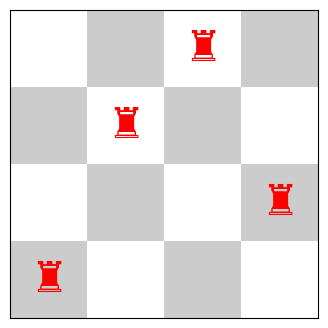


Solution 10:


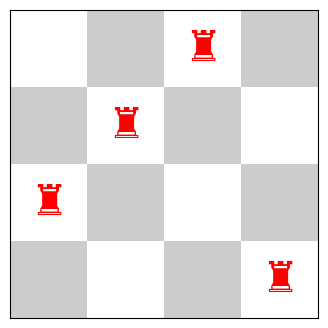


Solution 11:


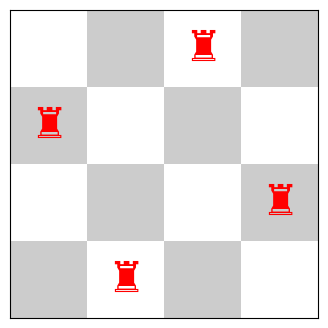


Solution 12:


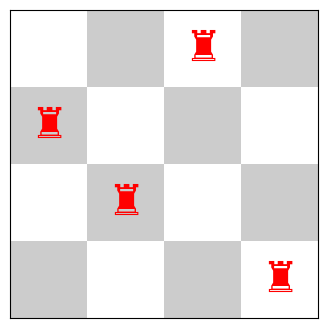


Solution 13:


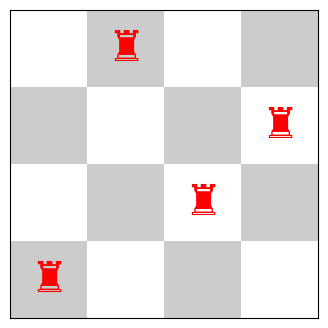


Solution 14:


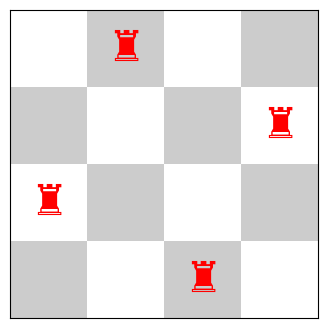


Solution 15:


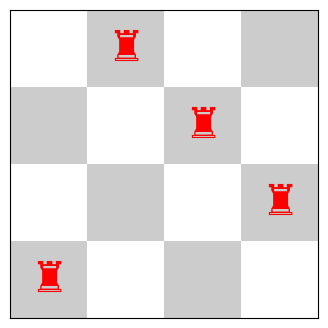


Solution 16:


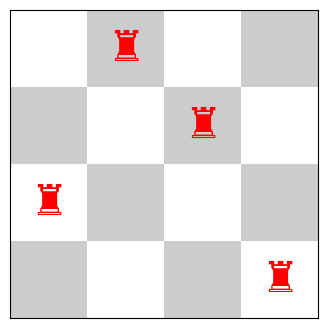


Solution 17:


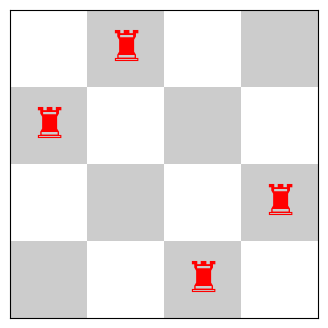


Solution 18:


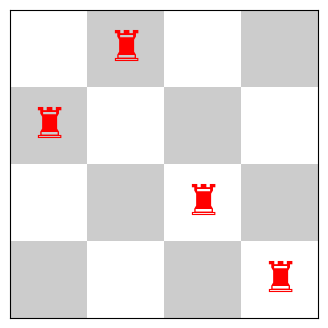


Solution 19:


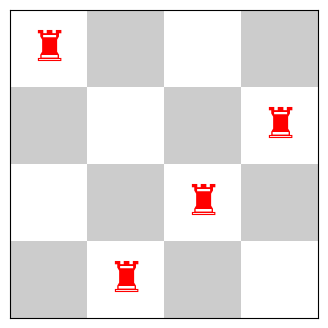


Solution 20:


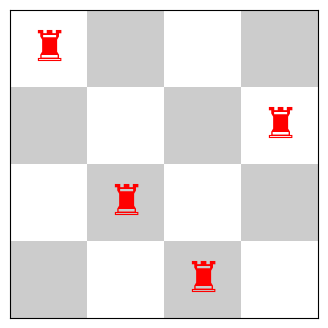


Solution 21:


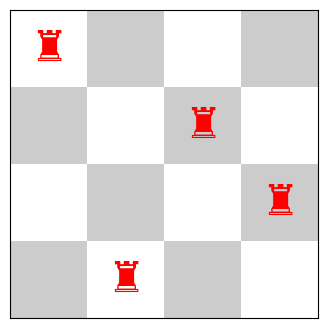


Solution 22:


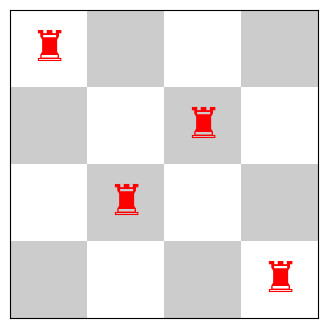


Solution 23:


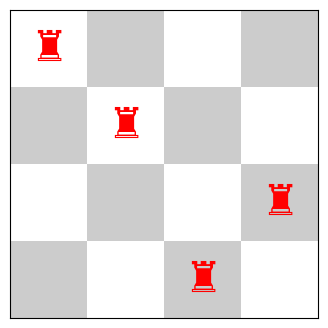


Solution 24:


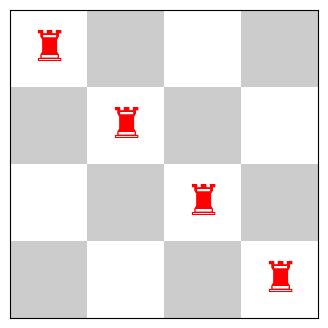

In [169]:
# Extract results
N = results_rook_4["N"]
states = results_rook_4["states"]
probs_list = results_rook_4["probs_list"]
min_energy_states = results_rook_4["min_energy_states"]

'''
# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]


# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Rooks")
plt.tight_layout()
plt.show()
'''

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='rook')
    print()

# 1.2 Finding a specific solution for the rook puzzle

As you might have seen before, the solution obtained using the previous hamiltonian is usually a superposition of all possible configurations of rooks on the board. To obtain a single solution, we must break the degeneracy of the solution by unbalancing the positions in which the rooks appear.

One of the simplest ways to do this is "tilting" the chess board, i.e., favoring the positioning of the rooks on one side of the board. To do this, one can add a small bias on the single-body terms of the form:

- $b_{00}$ <- $b_{00}$
- $b_{01}$ <- $b_{01}$ + $\delta$
- $b_{02}$ <- $b_{02}$ + $\sqrt{2}\delta$
- ...
- $b_{NN}$ <- $b_{NN}$ + $N\delta$

where $\delta$ should be small compared with the value of $b$ and $Q$, but not infinitely small. You might optimize this by comparing some solutions for different values of $\delta$, or maybe use your creativity to break the degeneracy using different weights and method.

## Introduce the modification on the one-body terms and run again all the steps of the algorithm to find a solution of the rook puzzle. What is the accuracy for the algorithm to find the solution?

> Extra: Can you implement this bias also for the brute force search?

In [ ]:
def quantum_hamiltonian_onebody_tilted(N, favor_cell, favor_cell2, delta=0.05):

    # Parámetros del término clásico
    b_k = -1.0 #-1.0
    factor = 0.5 * b_k 

    n_qubits = N * N

    # Lista de labels strings de matrices pauli
    labels = []
    coeffs = [] # 

    for i in range(N):
        for j in range(N):
            q = i * N + j
            label = ['I'] * n_qubits 
            label[n_qubits - 1 - q] = 'Z'                                                           #El Qubit 0 es último carácter del string por convención Qiskit
            labels.append(''.join(label))
            
            # Determine row and column of this qubit
            
            bias = 0
            if (i,j)==favor_cell or (i,j)==favor_cell2:
                bias -= delta # favor qubits in these cells
            
            coeffs.append(factor+bias)

    # Crear el operador cuántico
    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    
    print(coeffs)

    return H

def cost_hamiltonian_rooks_tilted(N,cell_bias,cell_bias2,delta):

    H_one = quantum_hamiltonian_onebody_tilted(N,cell_bias,cell_bias2,delta)
    H_two = quantum_hamiltonian_rooks_twobody_opt(N)

    hamiltonian = H_one + H_two #subir el castigo siempre ayuda

    return hamiltonian

[-0.6, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.6, -0.5]


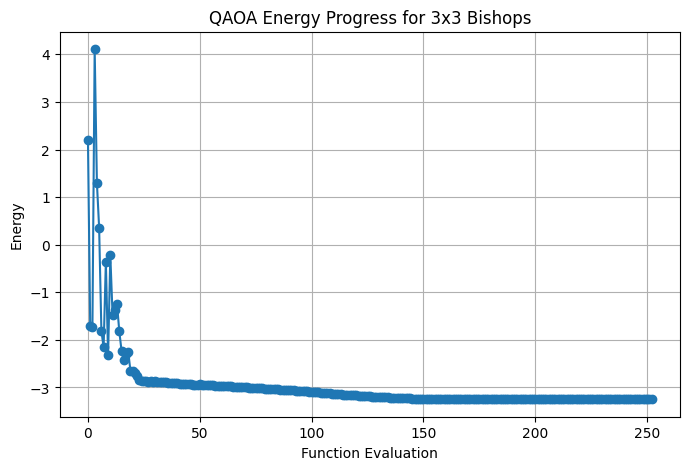

Optimal parameters: [2.46821516 3.29336614 0.33600955 1.57030653]
Minimum energy found: -3.2486434082086286


In [197]:
def rooks_problem_tilted_run(N, favor_cell, favor_cell2, delta=0.05):

    # Build cost Hamiltonian
    Cost_H = cost_hamiltonian_rooks_tilted(N, favor_cell, favor_cell2, delta)
    
    # Run QAOA
    optimal_params, min_energy, qc_opt = QAOA(N, Cost_H,'Bishops', p=2)

    print("Optimal parameters:", optimal_params)
    print("Minimum energy found:", min_energy)
    
    # Compute final state
    state = Statevector.from_instruction(qc_opt)

    # Get probabilities of each computational basis state (dict keeps insertion order in Python 3.7+)
    probs = state.probabilities_dict()

    # Keep original order
    states = list(probs.keys())
    probs_list = list(probs.values())

    # Find the most probable (minimum energy) states
    max_prob = max(probs_list)
    min_energy_states = [bitstring for bitstring, prob in probs.items() if np.isclose(prob, max_prob)]

    # Save everything you’ll need later
    results = {
        "N": N,
        "optimal_params": optimal_params,
        "min_energy": min_energy,
        "states": states,
        "probs_list": probs_list,
        "min_energy_states": min_energy_states,
        "probs": probs,
    }

    return results

# Run for a 3x3 board and store results
favor_cells = [(0, 0), (2, 1)]
results_rook_tilted = rooks_problem_tilted_run(3,(0,0),(2,1),0.1)


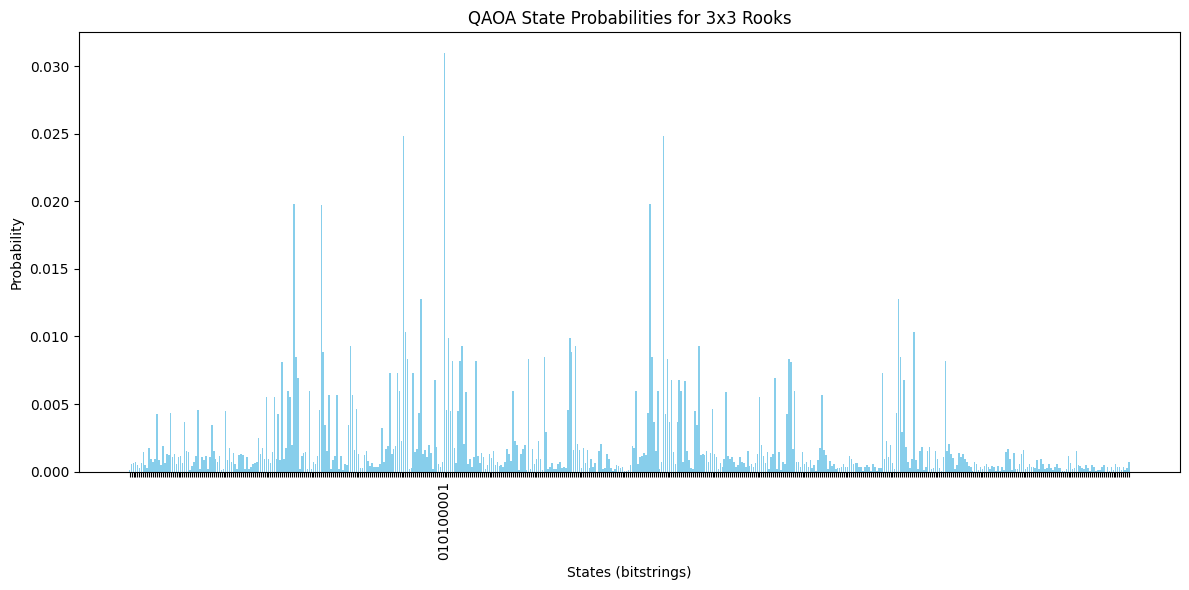

Most probable (minimum energy) states:
['010100001']
Solution 1:


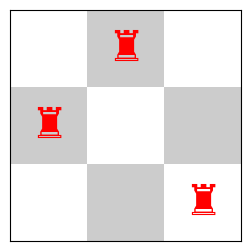

In [198]:
# Extract results
N = results_rook_tilted["N"]
states = results_rook_tilted["states"]
probs_list = results_rook_tilted["probs_list"]
min_energy_states = results_rook_tilted["min_energy_states"]

# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]

# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Rooks")
plt.tight_layout()
plt.show()

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='rook')
    print()

# 1.3 Improving the optimization

Now that everything is working properly, let's improve the QAOA protocol. Test the convergence of the solution and the parameters by changing different parameters of the algorithm.

Can you find a classical optimization algorithm that converges faster than the one by default on scipy.optimize? Does it change the result on the QAOA algorithm?

Does the convergence or the final solution improve using a different mixing operator?

How does the convergence and final solution change if we increase the number of layers from 2 to 3? How does the computation time change?

In [ ]:
# Test different possibilities here

def QAOA_rooks_global(N, cost_hamiltonian, p=2):
    n_qubits = N * N
    simulator = AerSimulator()
    energy_progress = []

    def qaoa_circuit(params):
        gamma = params[:p]
        beta = params[p:]
        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))  # initial superposition

        for layer in range(p):
            # Cost unitary
            for label, coeff in zip(cost_hamiltonian.paulis.to_labels(), cost_hamiltonian.coeffs):
                coeff_real = np.real(coeff)  # <-- ensure it's real
                qubits = [i for i, c in enumerate(label[::-1]) if c == 'Z']
                if len(qubits) == 1:
                    qc.rz(2 * coeff_real * gamma[layer], qubits[0])
                elif len(qubits) == 2:
                    qc.cx(qubits[0], qubits[1])
                    qc.rz(2 * coeff_real * gamma[layer], qubits[1])
                    qc.cx(qubits[0], qubits[1])
            # Mixer
            for q in range(n_qubits):
                qc.rx(2 * beta[layer], q)
        return qc

    def objective(params):
        qc = qaoa_circuit(params)
        energy = cost_function_rooks_estimator(cost_hamiltonian, qc)
        energy_progress.append(energy)
        return energy

    # Initial random parameters
    x0 = np.random.rand(2 * p) * np.pi
    
    #result = minimize(objective, x0)
    
    #Good
    #result = minimize(objective, x0, method='COBYLA')
    
    #Better
    #result = minimize(objective, x0, method='Nelder-Mead', options={'maxiter':10000, 'xatol':1e-6, 'fatol':1e-6})

    #Best, but more resource expensive -> Not working yet
    # Use differential evolution for global search
    bounds = [(0, np.pi) for _ in range(2 * p)]
    res_global = differential_evolution(objective, bounds, maxiter=500, polish=False)
    # Refine with local optimizer (Nelder-Mead)
    result = minimize(objective, res_global.x, method='Nelder-Mead', options={'maxiter': 10000, 'xatol': 1e-6, 'fatol': 1e-6})
    
    optimal_params = result.x
    min_energy = result.fun
    
    qc_opt = qaoa_circuit(optimal_params)
    
    # Plot energy at each optimization step
    plt.figure(figsize=(8, 5))
    plt.plot(energy_progress, marker='o')
    plt.xlabel("Function Evaluation")
    plt.ylabel("Energy")
    plt.title(f"QAOA Energy Progress for {N}x{N} Rooks")
    plt.grid(True)
    plt.show()

    return optimal_params, min_energy, qc_opt

# 2- Diagonal movement

As the queens can also move in diagonal, we will carefully analyze that movement playing the same game with bishops. (Be careful, this time for a board of NxN squares there are more than N possible bishops!!!!!!!!!!)

Repeat all previous steps with the bishops puzzle, to understand how can the diagonal movement be introduced in the hamiltonian. Fill all the following steps and comment everything you do to find the solution for 3x3 and 4x4 boards:

In [ ]:
# Create the brute force function to find the solutions of the bishop puzzle

import numpy as np           # Librería para crear y manejar matrices numéricas
import itertools             # Para generar combinaciones posibles de casillas

def classical_bishops(N):
    """
    Returns all valid solutions for placing bishops (that do NOT attack each other)
    on an NxN chess board.
    """
    solutions = []  # Lista donde se guardarán todas las soluciones válidas

    # Crear lista de todas las posiciones del tablero (pares de coordenadas)
    # Ejemplo: [(0,0), (0,1), ..., (N-1, N-1)]
    positions = [(r, c) for r in range(N) for c in range(N)]

    # 🔁 Generar todas las combinaciones posibles de casillas con 1 hasta N² alfiles
    for k in range(1, N*N + 1):
        for combo in itertools.combinations(positions, k):

            valid = True  # Asumimos que la combinación es válida hasta comprobar lo contrario
            used_diag1 = set()  # Guarda valores de (r - c) → diagonal principal ↘
            used_diag2 = set()  # Guarda valores de (r + c) → diagonal secundaria ↙

            # 🔍 Comprobamos si hay conflicto diagonal entre los alfiles del combo
            for (r, c) in combo:
                if (r - c) in used_diag1 or (r + c) in used_diag2:
                    valid = False
                    break  # Si hay conflicto, salimos del bucle
                used_diag1.add(r - c)
                used_diag2.add(r + c)

            # ✅ Si no hay conflictos, añadimos la solución
            if valid:
                board = np.zeros((N, N), dtype=int)  # Creamos tablero vacío
                for (r, c) in combo:
                    board[r, c] = 1  # Colocamos un alfil en cada posición válida
                solutions.append(board)

    return solutions  # Devuelve todas las soluciones válidas

# ============================================================
# 🧪 Ejemplo de ejecución
# ============================================================

sol3 = classical_bishops(3)
sol4 = classical_bishops(4)

print(f"3x3 → {len(sol3)} soluciones válidas")
print(f"4x4 → {len(sol4)} soluciones válidas\n")

# Mostrar todas las soluciones de 3x3
for i, s in enumerate(sol3):
    print(f"Solución {i+1}:\n{s}\n")

# Mostrar todas las soluciones de 4x4
for i, s in enumerate(sol4):
    print(f"Solución {i+1}:\n{s}\n")

In [ ]:
# Create the coefficients of the classical cost function for the bishop puzzle

def classical_hamiltonian_bishop_twobody_coeff(N: int, Q_k =1.5) -> np.ndarray:

    '''
    #Returns the NxNxNxN tensor Q_{kα, lβ} of pairwise interaction weights for the classical rooks problem.
    # Q[k, α, l, β] = 1.5 if squares (k, α) and (l, β) are in the same row or column, and 0 otherwise.

    Q_k = 1.5
    Q_tensor = np.zeros((N, N, N, N))

    for k in range(N):         # row index of first rook
        for alpha in range(N): # col index of first rook
            for l in range(N): # row index of second rook
                for beta in range(N): # col index of second rook
                    if (k == l and alpha == beta):
                        continue  # same square → no self-interaction
                    # If same row or same column
                    if k == l or alpha == beta:
                        Q_tensor[k, alpha, l, beta] = Q_k

    '''

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]

    conflict = (np.abs(rows - rows2) == np.abs(cols - cols2)) & ~((rows == rows2) & (cols == cols2))
    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k

    print(Q_tensor)

    return Q_tensor

def classical_hamiltonian_bishops(N: int, X_string: np.ndarray) -> float:

    H_b= classical_hamiltonian_rook_onebody_coeff(N) #Same for all pieces
    H_Q=classical_hamiltonian_bishop_twobody_coeff(N)

    H = H_b + H_Q

    # First, reshape x to (N,N,1,1) and (1,1,N,N)
    x1 = X_string[:,:,None,None]
    x2 = X_string[None,None,:,:]

    # Elementwise multiply and sum
    energy = np.sum(H * x1 * x2)

    return energy

state=np.array([[1,1,0],[0,0,0],[0,0,0]])
classical_hamiltonian_rooks(3,state)

In [216]:
# Create the hamiltonian operator for the bishop puzzle, add the tilting

def quantum_hamiltonian_bishop_twobody_coeff(N, Q_k=1.5):

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]
    
    #Solo hay que cambiar la condicion de conflicto! YEAH!
    conflict = (np.abs(rows - rows2) == np.abs(cols - cols2)) & ~((rows == rows2) & (cols == cols2))

    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k
    
    #print(Q_tensor)

    # Loop over pairs of squares to create ZZ terms
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if not conflict[k, alpha, l, beta]:
                        continue
                    J = 0.25 * Q_tensor[k, alpha, l, beta]
                    if J == 0:
                        continue
                    q1 = k * N + alpha
                    q2 = l * N + beta
                    label = ['I'] * n_qubits
                    label[n_qubits - 1 - q1] = 'Z'
                    label[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label))
                    coeffs.append(J)

    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    return H

def cost_hamiltonian_bishop_tilted(N,cell_bias,cell_bias2,delta):

    H_one = quantum_hamiltonian_onebody_tilted(N,cell_bias,cell_bias2,delta)
    H_two = quantum_hamiltonian_bishop_twobody_coeff(N,0.5)

    hamiltonian = H_one + 5*H_two

    return hamiltonian


[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]


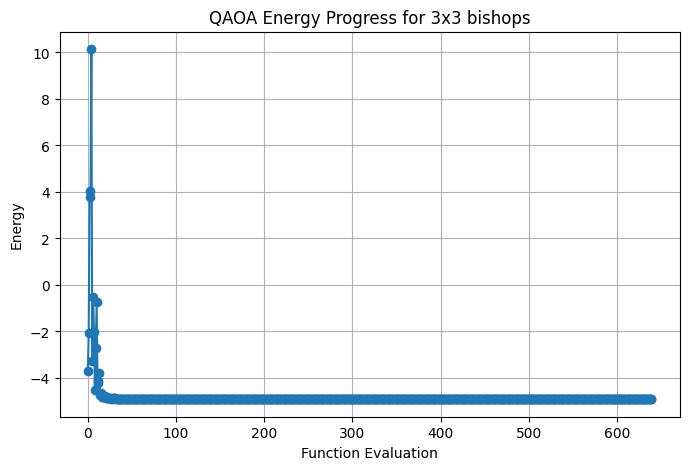

Optimal parameters: [0.99942138 2.55364393 2.30564861 0.50705164]
Minimum energy found: -4.912456960754057


In [219]:
# Run the QAOA algorithm with the bishop puzzle to find the solutions and compare it with brute force ones

def bishops_problem(N, favor_cell, favor_cell2, delta=0.05):

    # Build cost Hamiltonian
    Cost_H = cost_hamiltonian_bishop_tilted(N, favor_cell, favor_cell2, delta)
    
    # Run QAOA
    optimal_params, min_energy, qc_opt = QAOA(N, Cost_H,'bishops')

    print("Optimal parameters:", optimal_params)
    print("Minimum energy found:", min_energy)
    
    # Compute final state
    state = Statevector.from_instruction(qc_opt)

    # Get probabilities of each computational basis state (dict keeps insertion order in Python 3.7+)
    probs = state.probabilities_dict()

    # Keep original order
    states = list(probs.keys())
    probs_list = list(probs.values())

    # Find the most probable (minimum energy) states
    max_prob = max(probs_list)
    min_energy_states = [bitstring for bitstring, prob in probs.items() if np.isclose(prob, max_prob)]

    # Save everything you’ll need later
    results = {
        "N": N,
        "optimal_params": optimal_params,
        "min_energy": min_energy,
        "states": states,
        "probs_list": probs_list,
        "min_energy_states": min_energy_states,
        "probs": probs,
    }

    return results

# Run for a 3x3 board and store results
favor_cells = [(0, 0), (2, 1)]
results_bishops = bishops_problem(3,(0,0),(2,1),0)

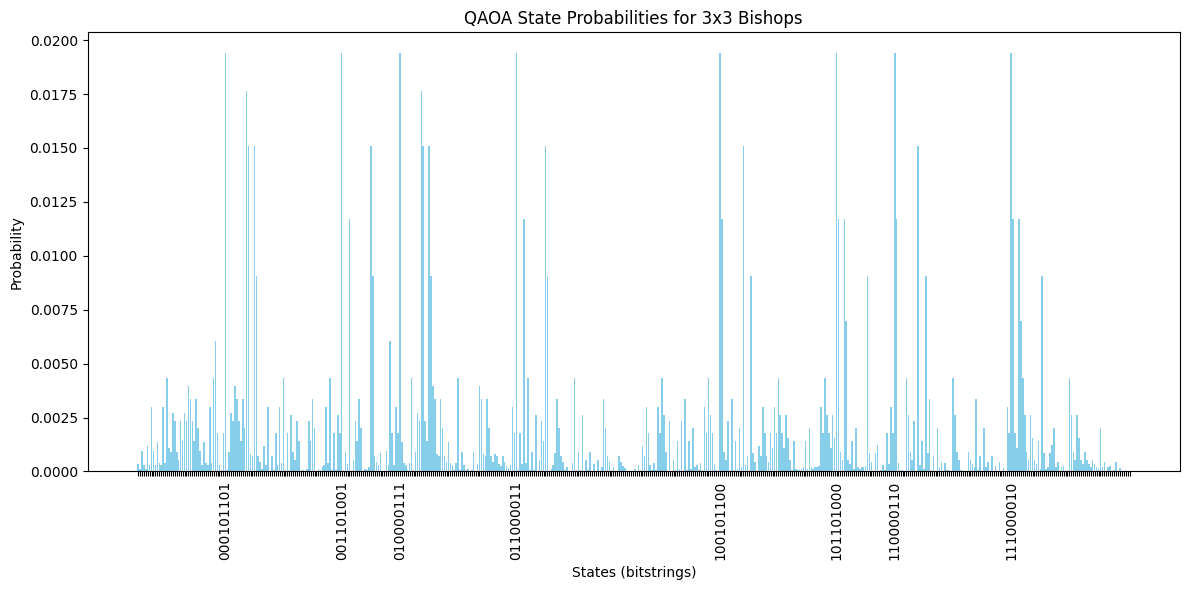

Most probable (minimum energy) states:
['000101101', '001101001', '010000111', '011000011', '100101100', '101101000', '110000110', '111000010']
Solution 1:


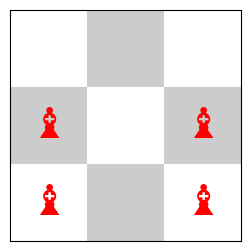


Solution 2:


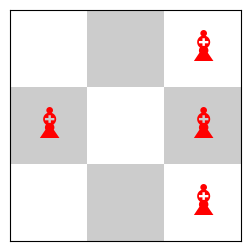


Solution 3:


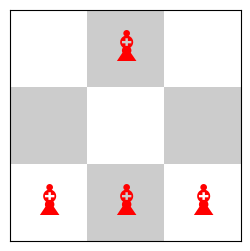


Solution 4:


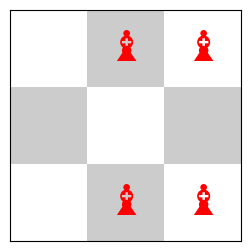


Solution 5:


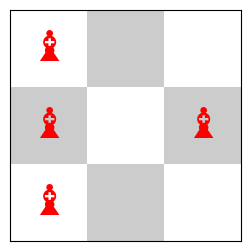


Solution 6:


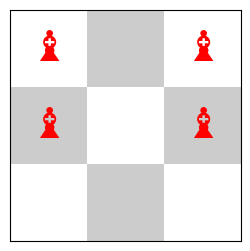


Solution 7:


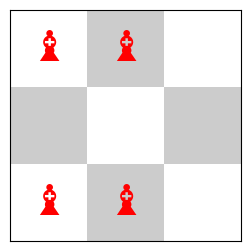


Solution 8:


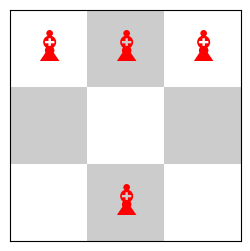

In [221]:
# Extract results
N = results_bishops["N"]
states = results_bishops["states"]
probs_list = results_bishops["probs_list"]
min_energy_states = results_bishops["min_energy_states"]

# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]

# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Bishops")
plt.tight_layout()
plt.show()

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='bishop')
    print()

# 3- The queens puzzle

Now that we have analyzed both movements of the queens, we can put everything together and find a solution for the queens problem. For that, you only need to combine the two body interactions of the rooks with those of the bishops and voila! The queens cost hamiltonian is done!

Repeat again the previous steps to find the solution for the queens puzzle for 3x3 and 4x4 boards. You can jump some steps if you find them unnecessary, but at the end you should compare the brute force solutions with those obtained by QAOA

In [ ]:
# Create the brute force function to find the solutions of the queens puzzle

# Create the brute force function to find the solutions of the queens puzzle

import numpy as np
import itertools

def classical_queens(N):
    """
    Devuelve todas las soluciones del problema de N reinas en un tablero N×N.
    Coloca exactamente N reinas (una por fila y una por columna) sin ataques diagonales.

    Returns:
        list[np.ndarray]: Lista de tableros (N,N) con 1 donde hay reina y 0 en otro caso.
    """
    solutions = []
    # perm[r] = columna donde va la reina de la fila r
    for perm in itertools.permutations(range(N)):
        diag1 = set()  # r - c
        diag2 = set()  # r + c
        ok = True
        for r, c in enumerate(perm):
            d1, d2 = r - c, r + c
            if d1 in diag1 or d2 in diag2:
                ok = False
                break
            diag1.add(d1); diag2.add(d2)
        if ok:
            board = np.zeros((N, N), dtype=int)
            for r, c in enumerate(perm):
                board[r, c] = 1
            solutions.append(board)
    return solutions

# Prueba rápida
sol3 = classical_queens(3)
sol4 = classical_queens(4)
print(f"N=3 → {len(sol3)} soluciones (esperado: 0)")
print(f"N=4 → {len(sol4)} soluciones (esperado: 2)")
for s in sol4:
    print(s, "\n")


In [ ]:
# Create the coefficients of the classical cost function for the queens puzzle
def classical_hamiltonian_queen_twobody_coeff(N: int, Q_k =1.5) -> np.ndarray:

    '''
    #Returns the NxNxNxN tensor Q_{kα, lβ} of pairwise interaction weights for the classical rooks problem.
    # Q[k, α, l, β] = 1.5 if squares (k, α) and (l, β) are in the same row or column, and 0 otherwise.

    Q_k = 1.5
    Q_tensor = np.zeros((N, N, N, N))

    for k in range(N):         # row index of first rook
        for alpha in range(N): # col index of first rook
            for l in range(N): # row index of second rook
                for beta in range(N): # col index of second rook
                    if (k == l and alpha == beta):
                        continue  # same square → no self-interaction
                    # If same row or same column
                    if k == l or alpha == beta:
                        Q_tensor[k, alpha, l, beta] = Q_k

    '''

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]

    #Solo cambia la situacion de conflicto
    conflict = ((rows == rows2) | (cols == cols2) | (np.abs(rows - rows2) == np.abs(cols - cols2))) & ~((rows == rows2) & (cols == cols2))
    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k

    print(Q_tensor)

    return Q_tensor


def classical_hamiltonian_queen(N: int, X_string: np.ndarray) -> float:

    H_b= classical_hamiltonian_rook_onebody_coeff(N) #Same for all pieces
    H_Q=classical_hamiltonian_queen_twobody_coeff(N)

    H = H_b + H_Q

    # First, reshape x to (N,N,1,1) and (1,1,N,N)
    x1 = X_string[:,:,None,None]
    x2 = X_string[None,None,:,:]

    # Elementwise multiply and sum
    energy = np.sum(H * x1 * x2)

    return energy

state=np.array([[1,1,0],[0,0,0],[0,0,0]])
classical_hamiltonian_queen(3,state)

In [ ]:
# Create the hamiltonian operator for the queens puzzle, add the tilting


def quantum_hamiltonian_queen_twobody_coeff(N, Q_k=1.5):

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]
    
    #Solo hay que cambiar la condicion de conflicto! YEAH!
    conflict = ((rows == rows2) | (cols == cols2) | (np.abs(rows - rows2) == np.abs(cols - cols2))) & ~((rows == rows2) & (cols == cols2))

    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k
    
    #print(Q_tensor)

    # Loop over pairs of squares to create ZZ terms
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if not conflict[k, alpha, l, beta]:
                        continue
                    J = 0.25 * Q_tensor[k, alpha, l, beta]
                    if J == 0:
                        continue
                    q1 = k * N + alpha
                    q2 = l * N + beta
                    label = ['I'] * n_qubits
                    label[n_qubits - 1 - q1] = 'Z'
                    label[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label))
                    coeffs.append(J)

    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    return H

def cost_hamiltonian_queens_tilted(N,cell_bias,cell_bias2,delta):

    H_one = quantum_hamiltonian_onebody_tilted(N,cell_bias,cell_bias2,delta)
    #H_two = quantum_hamiltonian_queen_twobody_coeff(N,0.5)
    H_two = 4.5*quantum_hamiltonian_bishop_twobody_coeff(N,0.1)+5*quantum_hamiltonian_rooks_twobody_opt(N,0.1)

    hamiltonian = H_one + H_two

    return hamiltonian



def cost_hamiltonian_queens_tilted(N,cell_bias,cell_bias2,delta):

    H_one = quantum_hamiltonian_onebody_tilted(N,cell_bias,cell_bias2,delta)
    H_two = quantum_hamiltonian_bishop_twobody_coeff(N)+quantum_hamiltonian_rooks_twobody_opt(N)

    hamiltonian = H_one + H_two

    return hamiltonian


In [ ]:
# Run the QAOA algorithm with the queens puzzle to find the solutions and compare it with brute force ones

def queens_problem(N, favor_cell, favor_cell2, delta=0.05):

    # Build cost Hamiltonian
    Cost_H = cost_hamiltonian_queens_tilted(N, favor_cell, favor_cell2, delta)
    
    # Run QAOA
    optimal_params, min_energy, qc_opt = QAOA(N, Cost_H, p=5)

    print("Optimal parameters:", optimal_params)
    print("Minimum energy found:", min_energy)
    
    # Compute final state
    state = Statevector.from_instruction(qc_opt)

    # Get probabilities of each computational basis state (dict keeps insertion order in Python 3.7+)
    probs = state.probabilities_dict()

    # Keep original order
    states = list(probs.keys())
    probs_list = list(probs.values())

    # Find the most probable (minimum energy) states
    max_prob = max(probs_list)
    min_energy_states = [bitstring for bitstring, prob in probs.items() if np.isclose(prob, max_prob)]

    # Save everything you’ll need later
    results = {
        "N": N,
        "optimal_params": optimal_params,
        "min_energy": min_energy,
        "states": states,
        "probs_list": probs_list,
        "min_energy_states": min_energy_states,
        "probs": probs,
    }

    return results

# Run for a 3x3 board and store results
results_queens = queens_problem(4,(0,0),(2,1),0)

[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]


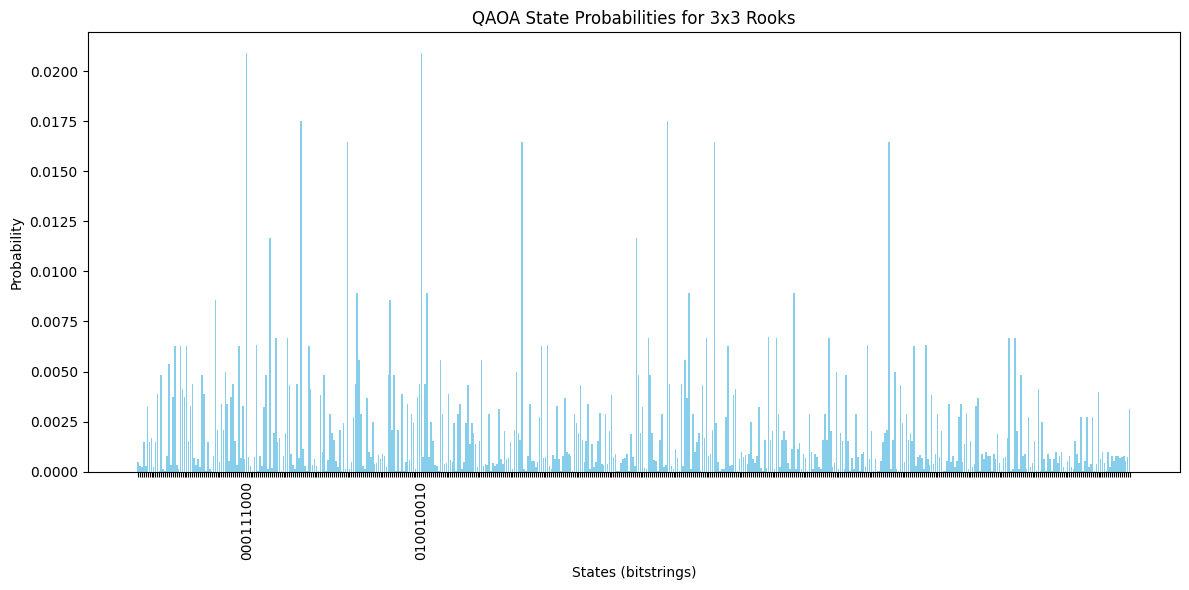

Most probable (minimum energy) states:
['000111000', '010010010']
Solution 1:


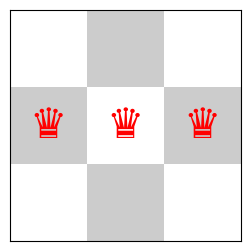


Solution 2:


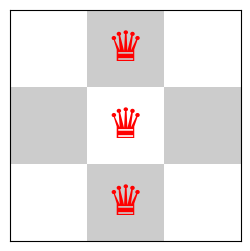

In [ ]:
# Extract results
N = results_queens["N"]
states = results_queens["states"]
probs_list = results_queens["probs_list"]
min_energy_states = results_queens["min_energy_states"]

# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]

# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Rooks")
plt.tight_layout()
plt.show()

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='queen')
    print()

In [ ]:
results_queens = queens_problem(4,(0,0),(2,1),0)

> Note: The 3x3 board solution only has 2 queens, while the 4x4 one has 4 queens.

# 4- Going to utility-scale problems

Now that you have solved small instances of the queens puzzle you might think, what's next?? Prepare for the most difficult and exciting part of the challenge!!

The previous sections where only restricted to 3x3 and 4x4 boards because bigger circuits are much expensive to simulate using classical computers and will take a lot of time to do the optimization. Then, you might think, Is this worthy?
Yes, it is. If we run it on a quantum computer!!
Try to run 5x5 and 6x6 boards on it!.

Go again to [IBM web](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) and try to run a bigger board instance in real quantum hardware.
For that you will need to register on ibm and you will have a maximum of 10 minutes of Q-computations, so be cautious. Plan everything before running it and save every result obtained to present it in the final report.

In [ ]:
# Your code here

# 5- A farm of horses

The queens and rooks and bishops move in lines, but what about horses?

Explore the possible configurations solutions for the horses puzzle for small boards. Is this problem as easy to converge than the other instances? Which is the biggest difference?

In [141]:
def quantum_hamiltonian_horse_twobody(N, Q_k=1.5):

    n_qubits = N * N
    labels = []
    coeffs = []

    # Build Q_tensor using the vectorized classical rule
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]
    
    #Solo hay que cambiar la condicion de conflicto! YEAH!
    conflict = (((np.abs(rows - rows2) == 2) & (np.abs(cols - cols2) == 1)) | ((np.abs(rows - rows2) == 1) & (np.abs(cols - cols2) == 2)))

    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k
    
    #print(Q_tensor)

    # Loop over pairs of squares to create ZZ terms
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if not conflict[k, alpha, l, beta]:
                        continue
                    J = 0.25 * Q_tensor[k, alpha, l, beta]
                    if J == 0:
                        continue
                    q1 = k * N + alpha
                    q2 = l * N + beta
                    label = ['I'] * n_qubits
                    label[n_qubits - 1 - q1] = 'Z'
                    label[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label))
                    coeffs.append(J)

    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    print(H)
    return H

In [137]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def quantum_hamiltonian_horse_twobody(N, Q_k=1.5):
    """
    Builds the two-body Hamiltonian for the 'horse' (knight) constraint problem.
    Includes the full Ising expansion: (1 - Z_i - Z_j + Z_i Z_j)/4
    for each conflicting pair.
    """

    n_qubits = N * N
    labels = []
    coeffs = []

    # Knight-move conflict condition
    rows = np.arange(N)[:, None, None, None]
    cols = np.arange(N)[None, :, None, None]
    rows2 = np.arange(N)[None, None, :, None]
    cols2 = np.arange(N)[None, None, None, :]

    conflict = (((np.abs(rows - rows2) == 2) & (np.abs(cols - cols2) == 1)) |
                ((np.abs(rows - rows2) == 1) & (np.abs(cols - cols2) == 2)))

    # Build Q_tensor for penalty weights
    Q_tensor = np.zeros((N, N, N, N))
    Q_tensor[conflict] = Q_k

    # Loop through all conflicting pairs
    for k in range(N):
        for alpha in range(N):
            for l in range(N):
                for beta in range(N):
                    if not conflict[k, alpha, l, beta]:
                        continue
                    
                    J = Q_tensor[k, alpha, l, beta]
                    q1 = k * N + alpha
                    q2 = l * N + beta

                    # --- (1 - Z_i - Z_j + Z_iZ_j)/4 expansion ---
                    # Constant term: +1
                    labels.append('I' * n_qubits)
                    coeffs.append(0.25 * J)

                    # -Z_i term
                    label_i = ['I'] * n_qubits
                    label_i[n_qubits - 1 - q1] = 'Z'
                    labels.append(''.join(label_i))
                    coeffs.append(-0.25 * J)

                    # -Z_j term
                    label_j = ['I'] * n_qubits
                    label_j[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label_j))
                    coeffs.append(-0.25 * J)

                    # +Z_i Z_j term
                    label_ij = ['I'] * n_qubits
                    label_ij[n_qubits - 1 - q1] = 'Z'
                    label_ij[n_qubits - 1 - q2] = 'Z'
                    labels.append(''.join(label_ij))
                    coeffs.append(0.25 * J)

    H = SparsePauliOp.from_list(list(zip(labels, coeffs)))
    print(H)
    return H


In [142]:
def cost_hamiltonian_horse(N,cell_bias,cell_bias2,delta):

    H_one = quantum_hamiltonian_onebody_tilted(N,cell_bias,cell_bias2,delta)
    H_horse = quantum_hamiltonian_horse_twobody(N)

    hamiltonian = H_one + H_horse #1000*H_bishop+1000*H_rook

    return hamiltonian

[-0.5, -0.5, -0.5, -0.5, -1.0, -0.5, -0.5, -0.5, -0.5]
SparsePauliOp(['IIIZIIIIZ', 'IZIIIIIIZ', 'IIZIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IZIIIIZII', 'IIIIIZZII', 'ZIIIIZIII', 'IIIZIIIIZ', 'IIZZIIIII', 'IIZIIIIZI', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIZII', 'ZIIIIIIZI', 'ZIIIIZIII'],
              coeffs=[0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j,
 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j,
 0.375+0.j, 0.375+0.j, 0.375+0.j, 0.375+0.j])


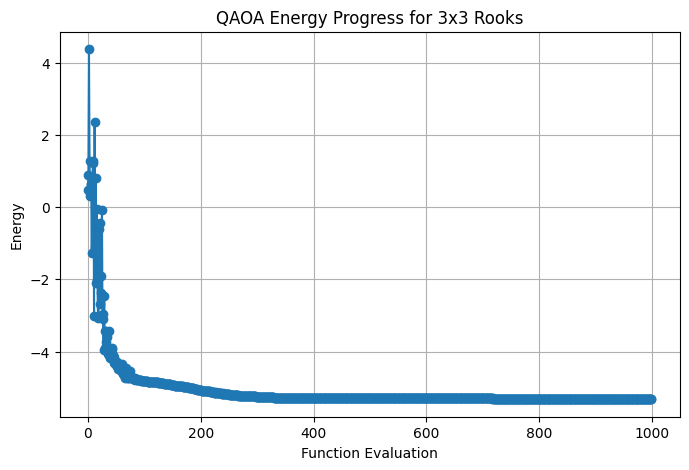

Optimal parameters: [-0.21356702  2.75167862  2.01857838  2.72479208  2.27802503  0.21725913
  4.76532513  1.17096313  1.59552505  1.32378836]
Minimum energy found: -5.316641413480074


In [271]:
def horse_problem(N, favor_cell, favor_cell2, delta=0.05):

    # Build cost Hamiltonian
    Cost_H = cost_hamiltonian_horse(N, favor_cell, favor_cell2, delta)
    
    # Run QAOA
    optimal_params, min_energy, qc_opt = QAOA(N, Cost_H, p=5)

    print("Optimal parameters:", optimal_params)
    print("Minimum energy found:", min_energy)
    
    # Compute final state
    state = Statevector.from_instruction(qc_opt)

    # Get probabilities of each computational basis state (dict keeps insertion order in Python 3.7+)
    probs = state.probabilities_dict()

    # Keep original order
    states = list(probs.keys())
    probs_list = list(probs.values())

    # Find the most probable (minimum energy) states
    max_prob = max(probs_list)
    min_energy_states = [bitstring for bitstring, prob in probs.items() if np.isclose(prob, max_prob)]

    # Save everything you’ll need later
    results = {
        "N": N,
        "optimal_params": optimal_params,
        "min_energy": min_energy,
        "states": states,
        "probs_list": probs_list,
        "min_energy_states": min_energy_states,
        "probs": probs,
    }

    return results

# Run for a 3x3 board and store results
results_horse = horse_problem(3,(1,1),(1,1),0.5) 

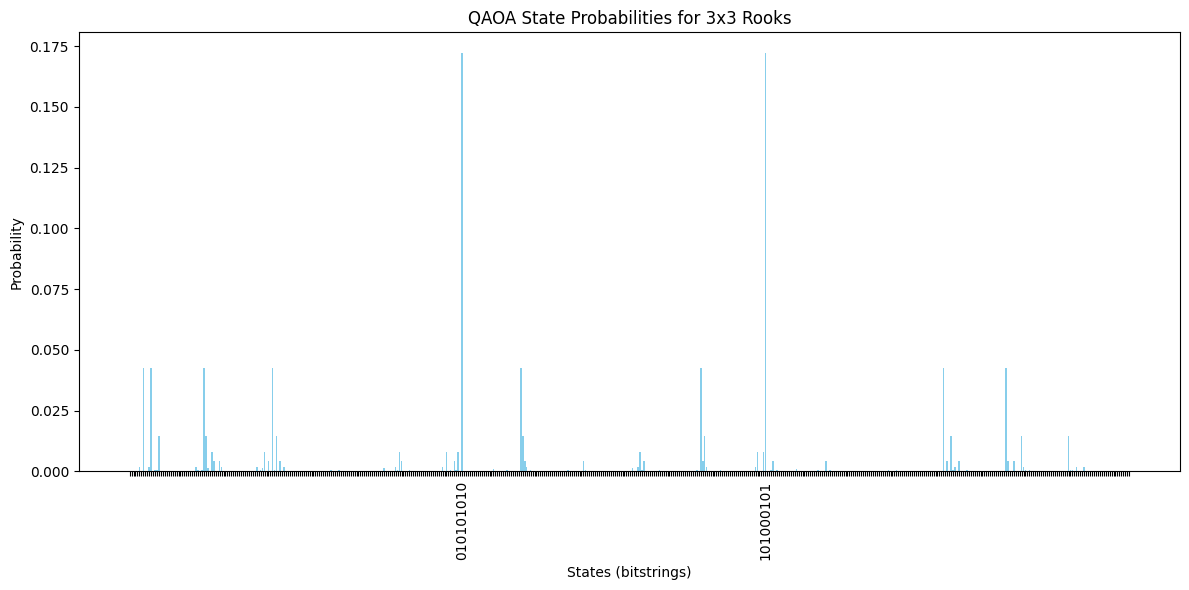

Most probable (minimum energy) states:
['010101010', '101000101']
Solution 1:


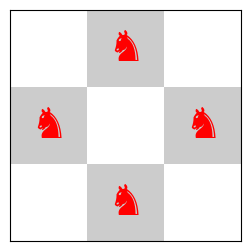


Solution 2:


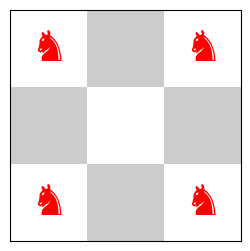

In [272]:
# Extract results
N = results_horse["N"]
states = results_horse["states"]
probs_list = results_horse["probs_list"]
min_energy_states = results_horse["min_energy_states"]

# Build labels: only show for most probable states
labels = [state if state in min_energy_states else "" for state in states]

# Plot probability distribution
plt.figure(figsize=(12,6))
plt.bar(range(len(states)), probs_list, color='skyblue')
plt.xticks(range(len(states)), labels, rotation=90)
plt.xlabel("States (bitstrings)")
plt.ylabel("Probability")
plt.title(f"QAOA State Probabilities for {N}x{N} Rooks")
plt.tight_layout()
plt.show()

print("Most probable (minimum energy) states:")
print(min_energy_states)

# --- Visualize configurations ---
def string_to_matrix(bitstring):
    n = int(np.sqrt(len(bitstring))) 
    matrix = np.array([int(b) for b in bitstring]).reshape(n, n)
    return matrix

matrices = [string_to_matrix(state) for state in min_energy_states]

for idx, mat in enumerate(matrices):
    print(f"Solution {idx+1}:")
    plot_checkerboard(mat, piece_type='horse')
    print()

# 6- A parallel story  (Truly challenging - research level)

Read the following works about the queens puzzle and compare what they propose with the things that we have done here:

- https://arxiv.org/html/2312.16312v1
- https://quantum-journal.org/papers/q-2019-06-03-149/

Based on those articles, which changes should be done to improve the resolution of the problem? Do you think that this will make a substantial change on your outcomes?

Can you improve the solution of the problem? Maybe propose a new mapping? Maybe use a different algorithm? 

Open solution question, let your imagination running!

In [ ]:
# Your code here